IMPORTS

In [14]:
# Python Module Imports
import os
import numpy as np
from time import perf_counter
import pickle

In [2]:
# External Imports
import cv2
from keras import Input
from keras.backend import abs as kerasAbs
from keras.models import Sequential, Model, load_model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, BatchNormalization, Activation
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN

In [3]:
# GUI Imports
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.messagebox import showerror

root = Tk()
root.withdraw()

''

HELPER FUNCTIONS

In [4]:
def MT_CNN(img, min_face_size=20, scale_factor=0.709):
    """
    Reads an Image and detects the faces in this image using
    a Pre-Trained Multi-task Cascaded Convolutional Neural Networks for Face Detection,
    based on TensorFlow.

    --Parameters--
    img - Matrix of the type CV_8U containing an image where objects are detected.
    min_face_size: Minimum possible object size. Objects smaller than that are ignored.
    scale_factor: Parameter specifying how much the image size is reduced at each image scale.

    """
    model = MTCNN(min_face_size=min_face_size, scale_factor=scale_factor)
    faces = model.detect_faces(img)
    faces = filter(lambda x: x['confidence'] >= 0.90, faces)
    return list(map(lambda x: x['box'], faces))

In [5]:
def resize_img(img, required_size=(105, 105)):
    """
    Resize the image to the required dimensions.
    """
    return cv2.resize(img, required_size)

In [6]:
def get_photo():
    """
    Accepts a photo from the user and returns it as a numpy array
    """
    filename = askopenfilename(
        title="Select Test Image",
        filetypes=[("Image Files", "*.jpg;*.jpeg;*.png;")],
        initialdir=os.getcwd(),
        parent=root
    )
    if filename:
        image = cv2.imread(filename)
    else:
        showerror("Error", "No File Selected.")
        raise SystemExit
    return image

In [7]:
def label_face(image, face, predicted, rect_color=(0, 255, 0), text_color=(0, 0, 0)):
    """
    Labels the face in the image with the predicted label
    image - the image to be labeled
    face - the face to be labeled
    predicted - the label to be applied
    rect_color - the color of the rectangle
    text_color - the color of the text
    """
    x, y, w, h = face
    font_size, font_thiccness = 0.7, 1
    l, b = cv2.getTextSize(
        predicted, cv2.FONT_HERSHEY_SIMPLEX, font_size, font_thiccness)[0]
    cv2.rectangle(image, (x, y), (x+w, y+h), rect_color, 2)
    cv2.rectangle(image, (x-1, y), (x+max(l, w)+1, y-b-10), rect_color, -1)
    cv2.putText(image, predicted, (x, y-6),
                cv2.FONT_HERSHEY_SIMPLEX, font_size, text_color, font_thiccness)
    return image

In [8]:
def locate_faces(image):
    """
    Detects faces in the image and returns their locations
    image - the image to be analyzed
    """
    faces_loc = MT_CNN(image, min_face_size=60, scale_factor=0.747)
    return faces_loc

In [9]:
def encode_faces(image, faces_loc):
    """
    Crops the faces from the image and returns their data
    image - the image to be analyzed
    faces_loc - the location of the faces
    """
    faces_data = []
    for (x, y, w, h) in faces_loc:
        face = image[y:y+h, x:x+w]
        face = resize_img(face)
        faces_data.append(face)

    return faces_data

FEW SHOT LEARNING TRAINING AND TESTING FUNCTIONS

In [18]:
# Constants
# N-way K-shot Learning
N = 6 # number of classes
K = 5 # number of images per class
LIMIT = 8 # number of images to be used for training

In [19]:
def load_images_custom(path = None, label = 0, mode = None):
    """
    Loads images from the given path and returns a list of images.
    path - the path from which to load the images
    label - the label of the images
    mode - the mode of the training.
    """
    if path is None:
        raise ValueError("Path is not defined")

    if mode is None:
        mode = 0

    elif isinstance(mode, int):
        if mode not in [0, 1]:
            raise ValueError("Mode should be either 0 or 1")

    elif isinstance(mode, str):
        if mode not in ["train", "val"]:
            raise ValueError("Mode should be either 'train' or 'val'")
        mode = {"train":0, "val":1}[mode]

    if LIMIT > 8:
        raise ValueError("LIMIT cannot be greater than 8 for this dataset.")

    classes = []
    labels = []
    current_label = label
    classes_dict = dict()
    target = 0
    valid_set = [{"Hiranmay", "Neel", "Shilpi"}, {"Shreya", "Srijani", "Richa"}][mode]
    
    for person in os.scandir(path):
        if person.is_dir():
            if person.name not in valid_set:
                continue
            print(f"Loading images from {person.name}")
            classes_dict[person.name] = [current_label, current_label]
            person_images = []
            for img_no, image in enumerate(os.scandir(person.path)):
                if image.is_file():
                    if img_no == LIMIT:
                        break
                    img = cv2.imread(image.path)
                    person_images.append(img)
                    labels.append(target)
                    classes_dict[person.name][1] = current_label
                    current_label += 1
            target += 1
            classes.append(np.stack(person_images))
    labels = np.vstack(labels)
    classes = np.stack(classes)

    return classes, labels, classes_dict

In [12]:
def load_images_omniglot(label = 0, mode = 0):
    if mode is None:
        mode = 0

    elif isinstance(mode, int):
        if mode not in [0, 1]:
            raise ValueError("Mode should be either 0 or 1")

    elif isinstance(mode, str):
        if mode not in ["train", "val"]:
            raise ValueError("Mode should be either 'train' or 'val'")
        mode = {"train":0, "val":1}[mode]
    
    if LIMIT > 20:
        raise ValueError("LIMIT cannot be greater than 20 for this dataset.")
    
    path = os.path.join("dataset", "omniglot", ["images_background", "images_evaluation"][mode])

    classes = []
    labels = []
    current_label = label
    classes_dict = dict()
    target = 0

    for alphabet in os.scandir(path):
        if alphabet.is_dir():
            print(f"Loading Alphabet : {alphabet.name}")
            classes_dict[alphabet.name] = [current_label, current_label]
            for letter in os.scandir(alphabet.path):
                letter_images = []
                for img_no, image in enumerate(os.scandir(letter.path)):
                    if image.is_file():
                        # if img_no == LIMIT:
                        #     break
                        img = cv2.imread(image.path)
                        letter_images.append(img)
                        labels.append(target)
                        classes_dict[alphabet.name][1] = current_label
                        current_label += 1
                target += 1
                classes.append(np.stack(letter_images))
    labels = np.vstack(labels)
    classes = np.stack(classes)

    return classes, labels, classes_dict

In [20]:
# X_train, y_train, c_train = load_images_custom("dataset/train/labelled data", mode = 0)
# X_val, y_val, c_val = load_images_custom("dataset/train/labelled data", mode = 1)
print("--------------Loading Omniglot--------------")
print("----------------TRAINING SET----------------")
X_train, y_train, c_train = load_images_omniglot(mode = 0)
print("---------------VALIDATION SET---------------")
X_val, y_val, c_val = load_images_omniglot(mode = 1)

Loading images from Hiranmay
Loading images from Neel
Loading images from Shilpi
Loading images from Richa
Loading images from Shreya
Loading images from Srijani


In [21]:
with open("custom.pkl", "wb") as f:
    pickle.dump([X_train, y_train, c_train, X_val, y_val, c_val], f)

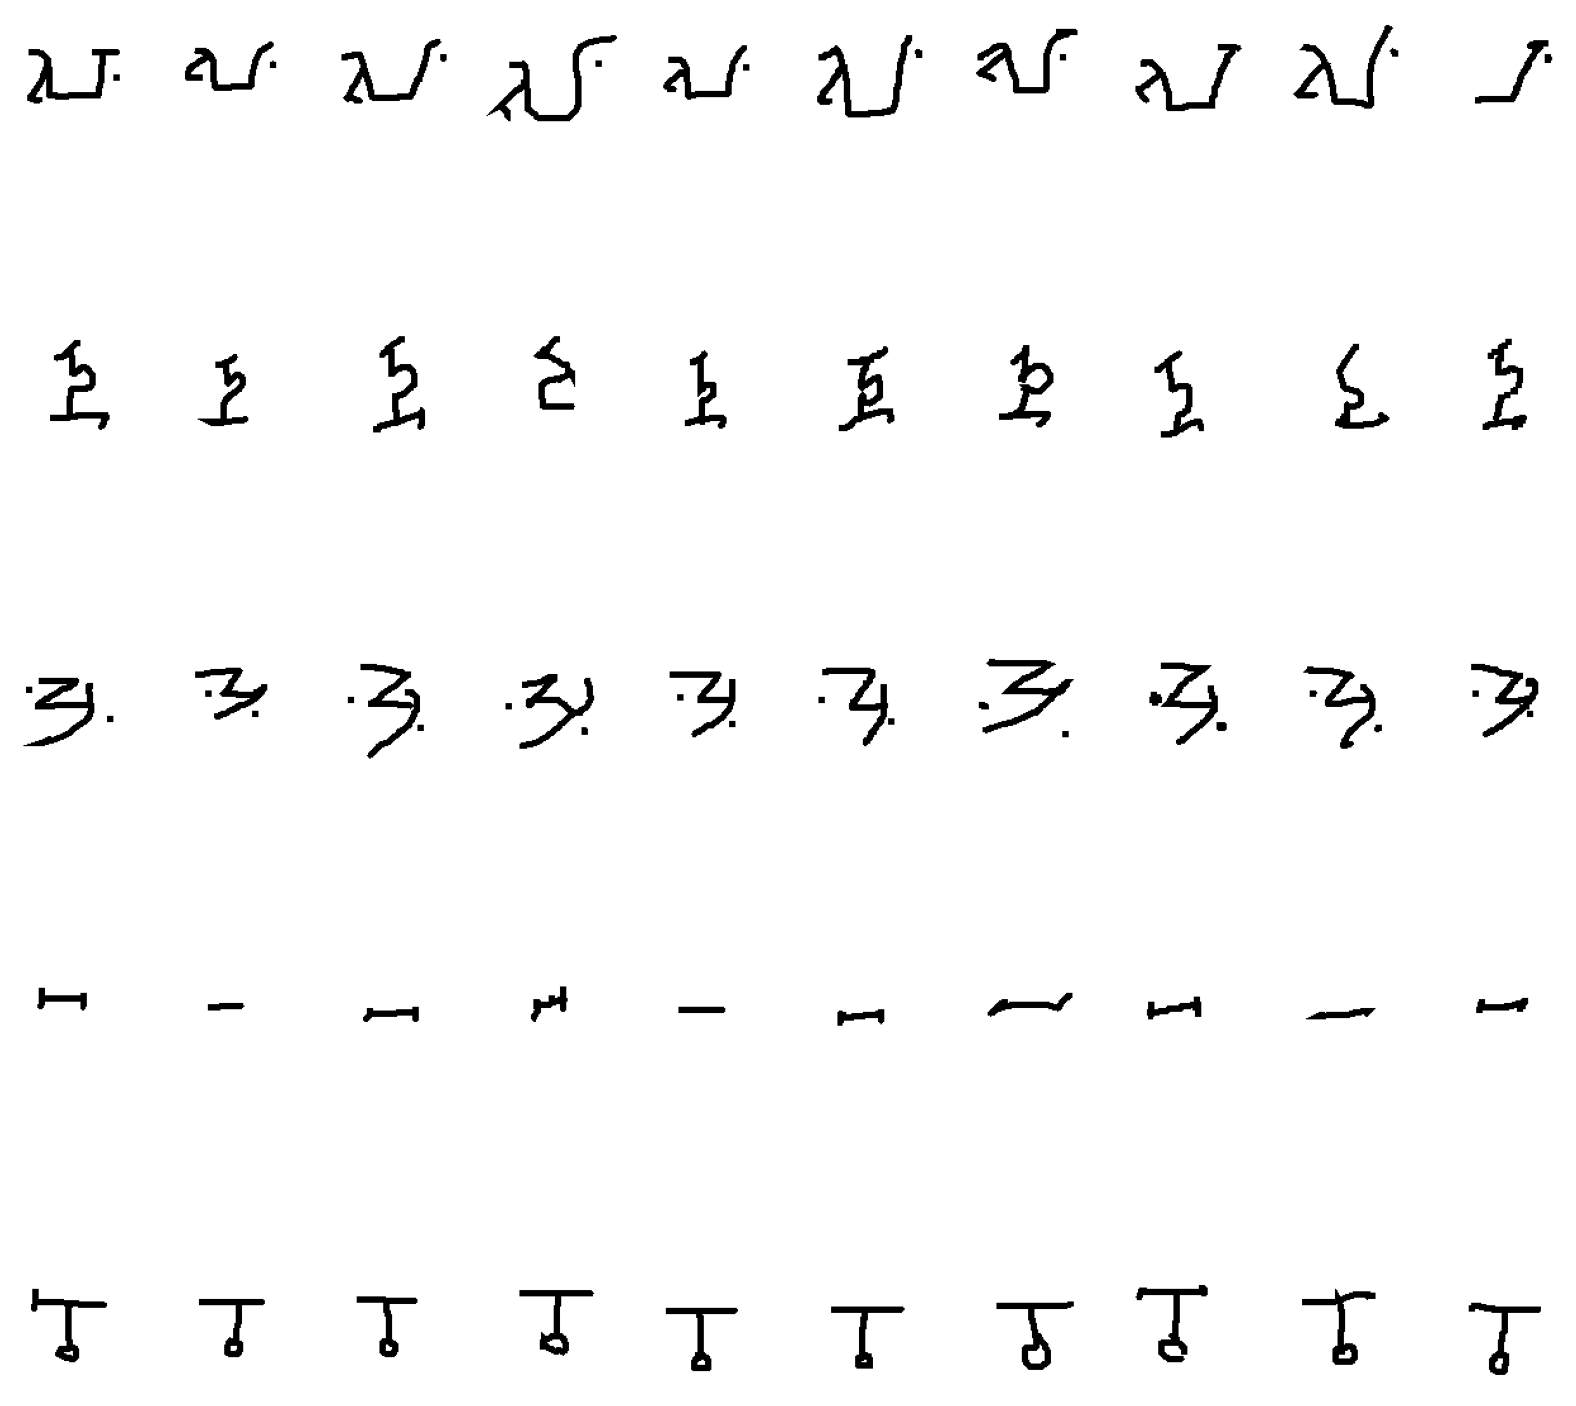

In [103]:
def test_load_images(N, LIMIT):
    """
    Tests the load_images function
    """
    mode = 0
    X = [X_train, X_val][mode]
    y = [y_train, y_val][mode]
    fig, axes = plt.subplots(nrows=N, ncols=LIMIT, figsize=(28, 28))
    for id, person, label in zip(range(N), X, y):
        for idx, img in enumerate(person[:LIMIT]):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[id, idx].imshow(img)
            axes[id, idx].axis('off')
    plt.show()
test_load_images(5, 10)

In [104]:
def load_batch(batch_size, mode = None, replace=False):
    """
    Loads a batch of images from the given mode.
    batch_size - the size of the batch
    mode - the mode of the training.
    """
    if mode is None:
        mode = 0

    elif isinstance(mode, int):
        if mode not in [0, 1]:
            raise ValueError("Mode should be either 0 or 1")

    elif isinstance(mode, str):
        if mode not in ["train", "val"]:
            raise ValueError("Mode should be either 'train' or 'val'")
        mode = {"train":0, "val":1}[mode]
        
    classes = [X_train, X_val][mode]
    n_classes, n_samples, width, height, channels = classes.shape
    
    random_classes = np.random.choice(n_classes, batch_size, replace=replace)
    
    training_pairs = [np.zeros((batch_size, width, height, channels)) for _ in range(2)]
    training_labels = np.zeros((batch_size,))

    training_labels[batch_size//2:] = 1

    for i in range(batch_size):
        class_id = random_classes[i]
        idx_1 = np.random.randint(0, n_samples)
        training_pairs[0][i,:,:,:] = classes[class_id, idx_1].reshape(width, height, 3)
        
        while True:
            idx_2 = np.random.randint(0, n_samples)
            if idx_2 != idx_1:
                break

        if i >= batch_size // 2:
            class_id2 = class_id 
        else: 
            class_id2 = (class_id + np.random.randint(1, n_classes)) % n_classes
        training_pairs[1][i] = classes[class_id2, idx_2].reshape(width, height, 3)
    
    return training_pairs, training_labels

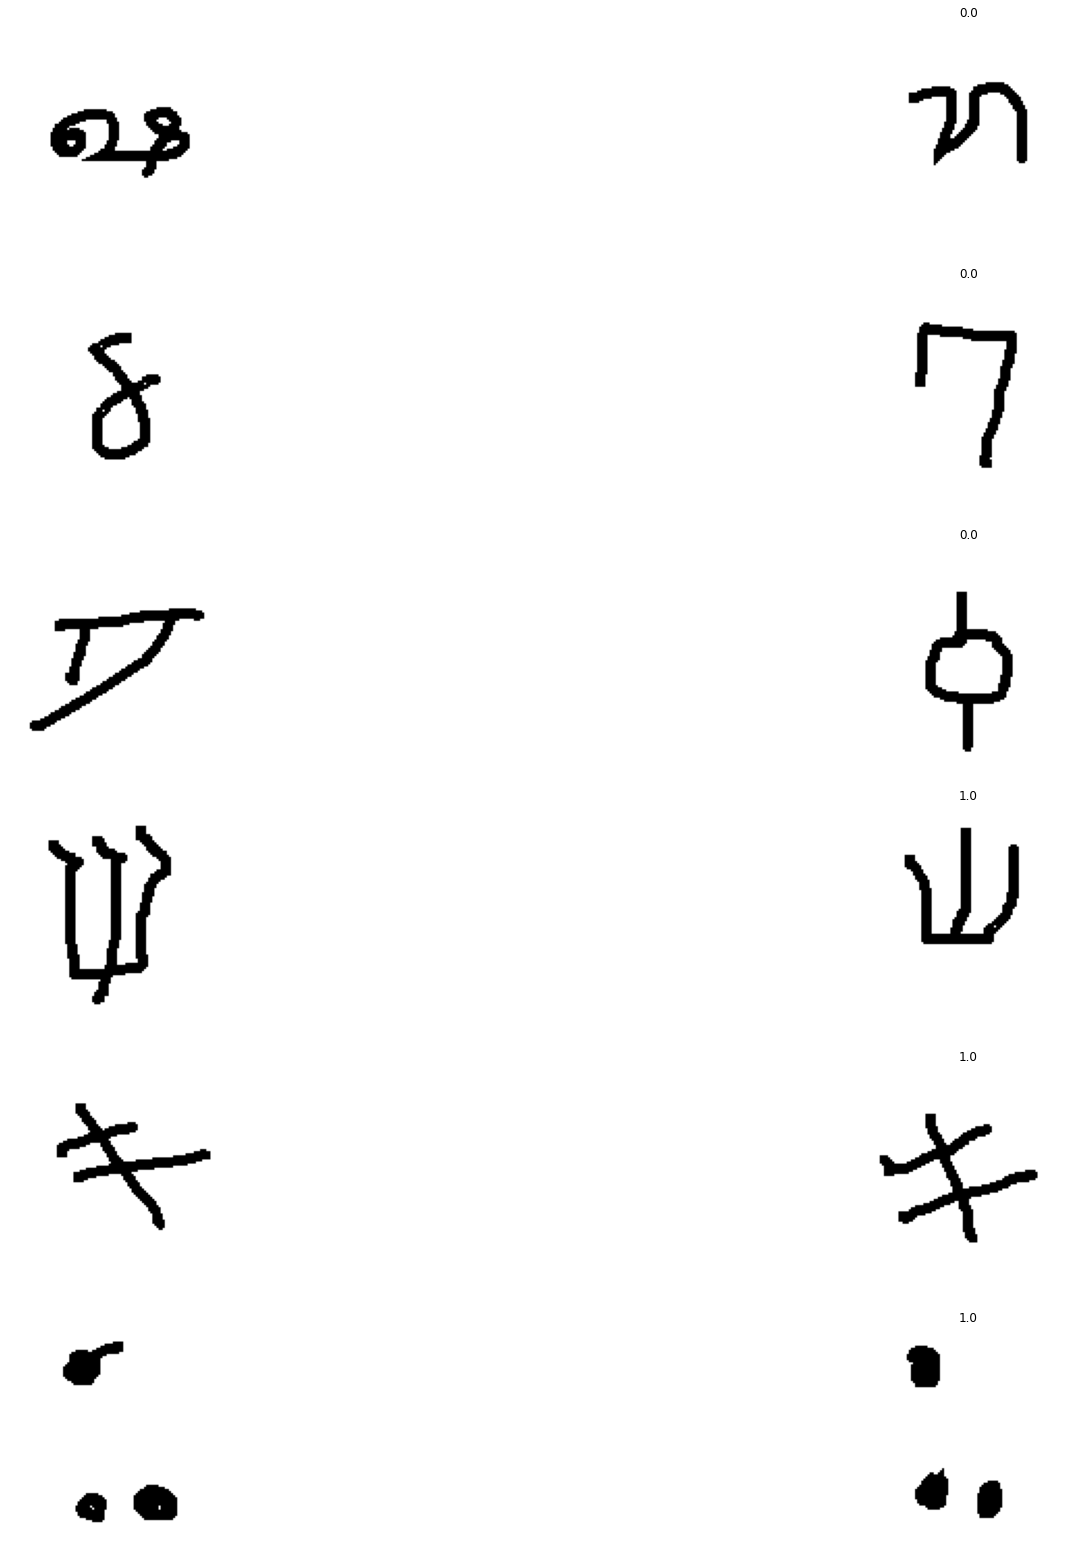

In [106]:
def test_load_batch():
    """
    Tests the load_batch function
    """
    batch_size = 6
    pairs, labels = load_batch(batch_size, mode = 0)
    fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(28, 28))
    for id, img1, img2 in zip(range(batch_size), pairs[0], pairs[1]):
        axes[id, 0].imshow(cv2.cvtColor(img1.astype('uint8'), cv2.COLOR_BGR2RGB))
        axes[id, 1].imshow(cv2.cvtColor(img2.astype('uint8'), cv2.COLOR_BGR2RGB))
        axes[id, 1].set_title(f"{labels[id]}")
        axes[id, 0].axis('off')
        axes[id, 1].axis('off')

    plt.show()
test_load_batch()

In [ ]:
def get_siamese_model(input_shape = (105, 105)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Convolution2D(64,(5,5),input_shape=input_shape,activation='relu',kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512,activation='sigmoid',kernel_regularizer='l2'))
    
    left_emb = model(left_input)
    right_emb = model(right_input)
    
    L1_Layer = Lambda(lambda tensors: kerasAbs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1,activation='sigmoid',kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=OP)
    
    siamese_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return siamese_net

In [ ]:
def generate(batch_size, mode = "train"):
    """
    A generator for batches of images.
    """
    while True:
        pairs, targets = load_batch(batch_size, mode)
        yield (pairs, targets)

In [ ]:
def train_model():
    """
    Trains the siamese network.
    """
    model = get_siamese_model()
    history = model.fit(generate(32, mode = "train"),
                        steps_per_epoch=20, 
                        validation_data=generate(32, mode = "val"),
                        validation_steps=10, 
                        epochs=50)
    return model, history


In [ ]:
def save_model(model, name = "model"):
    """
    Saves the model to a file
    model - the model to save
    name - the name of the file
    """
    model.save(f"{name}.h5")

In [ ]:
def evaluate_model(history):
    """
    Plots the training and validation accuracy and loss.
    history - the history of the model
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("Model_Accuracy.png")

    plt.clf()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("Model_Loss.png")

In [ ]:
def get_model(train = False):
    """
    Returns a newly trained model if train is set to True, otherwise returns the model from the saved file.
    train - Boolean, whether to train the model or to load it from a file.
    """
    if train:
        model, history = train_model()
        evaluate_model(history)
    else:
        model = load_model("OneShotModel_test.h5")
    return model

In [109]:
def load_support_set(K, input_shape=(105,105,3)):
    """
    Loads the support set of images
    K - the number of images to load
    input_shape - the shape of the images
    """
    support_set = [[None, None] for _ in range(N)]
    path = os.path.join(os.getcwd(), "dataset", "support_set")

    for person_no, person in enumerate(os.scandir(path)):
        label = person.name
        images = np.zeros((K, *input_shape))
        
        for img_no, image in enumerate(os.scandir(person.path)):
            if(img_no == K):
                break
            img = cv2.imread(image.path)
            img = resize_img(img, input_shape[:2])
            images[img_no,:,:,:] = img

        support_set[person_no] = [label, images]
    
    return support_set

In [ ]:
def test_load_support_set(N, K):
    """
    A function to test the load_support_set function.
    N - the number of people
    K - the number of images per person
    """
    support_set = load_support_set(K, (105,105,3))
    
    fig, axes = plt.subplots(N, K, figsize=(10, 10))

    for row, person in enumerate(support_set):
        name, images = person
        for col, image in enumerate(images):
            axes[row, col].imshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB))
            axes[row, col].set_title(f"{name}")
            axes[row, col].axis('off')
    plt.show()
    
test_load_support_set(6, 8)

In [155]:
def get_distance(model, test_img, support_images):
    """
    Returns the similarity score between the test and support images.
    test_img - the test image
    support_images - the support images
    """
    plt.imshow(test_img)
    plt.title(test_img.shape)
    plt.show()
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    test_img = resize_img(test_img, (105,105))
    dist = 0

    for image in support_images:
        plt.imshow(image)
        image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY)
        plt.show()
        dist += model.predict([test_img.reshape(1, 105, 105), image.reshape(1, 105, 105)])
    
    return dist / len(support_images)

In [125]:
def identify_faces(image, faces_loc, faces_data):
    """
    Identifies the faces in the image and labels them
    image - the image to be labeled
    faces_data - the data of the faces
    faces_loc - the location of the faces
    """
    model = get_model()
    support_set = load_support_set(K, (105, 105, 3))
    
    for face_loc, face_data in zip(faces_loc, faces_data):
        predictions = []

        for person in support_set:
            _, images = person
            dist_value = get_distance(model, face_data, images)
            predictions.append(dist_value)
        
        predicted = support_set[np.argmax(predictions)][0] if max(predictions) >= 0.5 else "Unknown"
        # cv2.imshow("Image", face_data)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # predicted = "Unknown"
        image = label_face(
            image,
            face_loc,
            predicted,
            rect_color=(46, 0, 230),
            text_color=(255, 255, 255)
        )
    return image

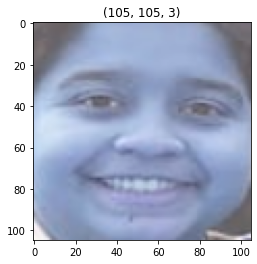

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


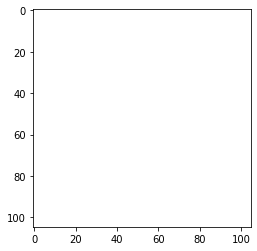

ValueError: in user code:

    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Users\James-PC\Desktop\Misc\Python\FaceDetectionCNN\venv\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 160, 160, 3), found shape=(None, 105, 105)


In [156]:
CP1 = perf_counter()
# image = get_photo()
image = cv2.imread("dataset\\test\\WhatsApp Image 2021-07-19 at 12.40.21 PM (1).jpeg")
CP2 = perf_counter()
faces_loc = locate_faces(image)
CP3 = perf_counter()
faces_data = encode_faces(image, faces_loc)
CP4 = perf_counter()
image = identify_faces(image, faces_loc, faces_data)
CP5 = perf_counter()
print(f'''Time Taken:
Load Image = {CP2-CP1} s
Locate Faces = {CP3-CP2} s
Encode Faces = {(CP4-CP3)*1000} ms
Identify Faces = {(CP5-CP4)*1000} ms''')
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("output.jpg", image)